In [12]:
import sys
import os
import ctypes


# Get the absolute path of the utils directory
utils_path = os.path.abspath("lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
class TilePacker:
    def __init__(self, *args):
        # Sort tiles by area once during initialization
        if len(args) <= 2:
            print("Construct based on unplaced tiles")
            if len(args) == 2:
                tiles = args[0]
                twoCut = args[1]
            else:
                tiles = args[0]
                twoCut = False
            self.tiles = tiles
            if not twoCut:
                print("sorted")
                self.tiles = sorted(tiles, key=lambda x: sum(w * h for w, h, _, _, _ in x), reverse=True)
            else:
                print("unsorted")
            self.placed_tiles = []
            self.bounding_width = 0
            self.bounding_height = max(dy + h for tile in tiles for _, h, _, dy, _ in tile)
        elif len(args) == 3:
            print("Construct based on placed tiles")
            placed_tiles = args[0]
            bounding_width = args[1]
            bounding_height = args[2]
            self.placed_tiles = placed_tiles
            self.bounding_width = bounding_width
            self.bounding_height = bounding_height

    def fits(self, x, tile, grid):
        """Check if a composite tile fits horizontally at position x."""
        for w, h, dx, dy,_ in tile:
            # Check if it fits within the grid width
            if x + dx + w > grid.shape[1]:
                return False
            # Check if space is occupied in the grid (optimized check)
            if np.any(grid[dy:dy + h, x + dx:x + dx + w] == 1):
                return False
        return True

    def place_tile(self, tile, grid):
        """Find the best position to place a composite tile horizontally."""
        for x in range(grid.shape[1]):
            if self.fits(x, tile, grid):
                # Place the tile in the grid
                for w, h, dx, dy,_ in tile:
                    grid[dy:dy + h, x + dx:x + dx + w] = 1
                return x  # Return x position where the tile is placed
        return -1  # Return -1 if the tile cannot be placed

    def pack_tiles(self):
        """Pack the tiles into a grid and return the bounding box dimensions."""
        max_width = sum(max(w + dx for w, _, dx, _,_ in tile) for tile in self.tiles)
        grid = np.zeros((self.bounding_height, max_width), dtype=int)
        count = 0

        # Precompute positions where each tile could fit
        fit_positions_cache = {}

        for tile in self.tiles:
            x_position = self.place_tile(tile, grid)
            if x_position == -1:
                print("Error: Tile doesn't fit, increase grid size.")
                break
            # Add the tile to placed tiles
            self.placed_tiles.append((x_position, tile))
            # Update bounding width
            self.bounding_width = max(self.bounding_width, x_position + max(dx + w for w, _, dx, _,_ in tile))

        return self.bounding_width, self.bounding_height, self.placed_tiles, grid

    def draw_packing_overlap(self, grid, seam_lst,epsilon, intra_color="tomato", inter_color="cyan"):
        """Draws the placement of tiles with color and boundaries."""
        fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
        ax.set_aspect('auto')

        # Define the grid size and spacing between cells
        cell_size = 1  # Define the size of each grid cell (uniform size)

        # Create a colormap for each tile
        colors = plt.cm.get_cmap("tab10", len(self.placed_tiles))
        # Draw each tile with a unique color and boundary
        for idx, (tile_x, tile) in enumerate(self.placed_tiles):  # Only unpack two values here
            for w, h, dx, dy, overlap in tile:
                if overlap:
                    rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor="yellow")
                else:
                    rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor=intra_color)
                for seam in seam_lst:
                    if overlap and dy < seam and dy + h >= seam:
                        rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor="olive")
                    elif dy < seam and dy + h >= seam:
                        rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor=inter_color)
                ax.add_patch(rect)

        # Set limits based on bounding box size
        ax.set_xlim(0, self.bounding_width)
        ax.set_ylim(0, self.bounding_height)

        # Hide the axis ticks for a cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        for seam in seam_lst:
            plt.axhline(seam - 0.5, color="purple", linewidth=3)
        plt.title(f"circuit depth = {self.bounding_width}, $\\epsilon$ = {epsilon}", fontsize = 24)
        plt.show()


In [14]:
def create_circuit_tile(excitations, overlap_lst):
    tile_lst = []
    for excitation in excitations:
        a,i = excitation
        if len(a) == 1:
            i1 = min([a[0], i[0]])
            i2 = max([a[0], i[0]])
            single_tile = [[(i2-i1)*2, i2-i1, 0, i1]]
            if excitation in overlap_lst:
                single_tile[0].append(1)
            else:
                single_tile[0].append(0)
            for _ in range(2):
                tile_lst.append(single_tile.copy())
        else:
            a.sort()
            i.sort()
            p,q = a
            k,m = i
            if set(a) & set(i) != set():
                j = list(set(a) & set(i))
                j = j[0]
                p,q = list(set(a) ^ set(i))
                i1 = min([p,q])
                i2 = max([p,q])
                if j < i1:
                    tile1 = [[(i2-i1)*2+2, i2-j, 0, j]]
                    tile2 = [[(i2-i1)*2, i2-i1, 0, i1]]
                elif j > i2:
                    tile1 = [[(i2-i1)*2+2, j-i1, 0, i1]]
                    tile2 = [[(i2-i1)*2, i2-i1, 0, i1]]
                else:
                    tile1 = [[(j-1-i1)*2+2+(i2-(j+1))*2, i2-i1, 0, i1]]
                    tile2 = [[(i2-i1)*2, i2-i1, 0, i1]]
                if excitation in overlap_lst:
                    tile1[0].append(1)
                    tile2[0].append(1)
                else:
                    tile1[0].append(0)
                    tile2[0].append(0)
                for _ in range(2):
                        tile_lst.append(tile1.copy())
                for _ in range(2):
                    tile_lst.append(tile2.copy())
            else:
                index_lst = [p,q,k,m]
                index_lst.sort()
                i1,i2,i3,i4 = index_lst
                cur_tile = [[(i2-i1)*2+(i4-i3)*2+2, i4-i1, 0, i1]]
                if excitation in overlap_lst:
                    cur_tile[0].append(1)
                else:
                    cur_tile[0].append(0)
                for _ in range(8):
                    tile_lst.append(cur_tile.copy())
    return tile_lst

def split_grid(tile_lst, seam_lst, twoCut = False):
    if twoCut:
        inter_tile = [[],[]]
        intra_tile = [[],[],[]]
        for tile in tile_lst:
            w,h,x,y,_ = tile[0]
            put = False
            for i in range(len(seam_lst)):
                seam = seam_lst[i]
                if y < seam and y+h >= seam:
                    inter_tile[i].append(tile.copy())
                    put = True
            if not put:
                if y+h < seam_lst[0]:
                    intra_tile[0].append(tile.copy())
                elif y>=seam_lst[1]:
                    intra_tile[-1].append(tile.copy())
                else:
                    intra_tile[1].append(tile.copy())
    else:
        inter_tile = []
        intra_tile = []
        for tile in tile_lst:
            w,h,x,y = tile[0]
            put = False
            for seam in seam_lst:
                if y < seam and y+h >= seam:
                    inter_tile.append(tile.copy())
                    put = True
            if not put:
                intra_tile.append(tile.copy())
    return inter_tile, intra_tile


In [15]:
def process_tiles(tiles, ratio, seam_lst):
    inter_tiles_lst, intra_tiles_lst = split_grid(tiles, seam_lst,twoCut=True)
    for inter_tiles in inter_tiles_lst:
        for i in range(len(inter_tiles)):
            inter_tiles[i][0] = inter_tiles[i][0].copy()
            inter_tiles[i][0][0] += int(2 * (ratio - 1)//1)

    post_tiles = []
    intra_tiles_up = sorted(intra_tiles_lst[2], key = lambda tile: tile[0][3])
    intra_tiles_mid = sorted(intra_tiles_lst[1], key = lambda tile: ((tile[0][3]+tile[0][1])*tile[0][3]), reverse=True)
    intra_tiles_down = sorted(intra_tiles_lst[0], key = lambda tile: (tile[0][3]+tile[0][1], tile[0][-1]))

    post_tiles = intra_tiles_up + intra_tiles_mid + intra_tiles_down

    inter_tiles_down = sorted(inter_tiles_lst[0], key = lambda tile: (tile[0][1]+tile[0][3], tile[0][1]), reverse=True)
    inter_tiles_up = sorted(inter_tiles_lst[1], key = lambda tile: (tile[0][1],tile[0][0]))
    if len(post_tiles) < len(inter_tiles_down) + len(inter_tiles_up):
        print("hi")
        post_tiles = inter_tiles_up + inter_tiles_down + post_tiles
    else:
        post_tiles = post_tiles + inter_tiles_down + inter_tiles_up    
    print(sum(tile[0][0] for tile in post_tiles))
    print(sum(tile[0][0] for tile in inter_tiles_up) + sum(tile[0][0] for tile in inter_tiles_down))
    return post_tiles

In [5]:
distance = 1.5
epsilon1 = 1e-3
epsilon2 = 7e-4
prehead ="C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/data_H_12/"
ansatz, excitations1,initial_state,hamiltonian = read_data_distance(distance, epsilon1,prehead)
ansatz, excitations2,initial_state,hamiltonian = read_data_distance(distance, epsilon2,prehead)

c:\Users\24835\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\qpy\interface.py:333: UserWarning: The qiskit version used to generate the provided QPY file, 1.3.2, is newer than the current qiskit version 1.3.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


In [6]:
from itertools import chain
overlaps = [sublist for sublist in excitations2 if sublist not in excitations1]

In [7]:
class DrawTilePacking(TilePacker):
    def draw_packing_overlap(self, grid, seam_lst,epsilon, intra_color="tomato", inter_color="cyan", new_inter_color = "olive"):
        """Draws the placement of tiles with color and boundaries."""
        fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)
        ax.set_aspect('auto')

        # Define the grid size and spacing between cells
        cell_size = 1  # Define the size of each grid cell (uniform size)

        # Create a colormap for each tile
        colors = plt.cm.get_cmap("tab10", len(self.placed_tiles))
        # Draw each tile with a unique color and boundary
        for idx, (tile_x, tile) in enumerate(self.placed_tiles):  # Only unpack two values here
            for w, h, dx, dy, overlap in tile:
                if overlap:
                    rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor="yellow")
                else:
                    rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor=intra_color)
                for seam in seam_lst:
                    if overlap and dy < seam and dy + h >= seam:
                        rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor=new_inter_color)
                    elif dy < seam and dy + h >= seam:
                        rect = patches.Rectangle((tile_x + dx, dy), w, h, facecolor=inter_color)
                ax.add_patch(rect)

        # Set limits based on bounding box size
        ax.set_xlim(0, self.bounding_width)
        ax.set_ylim(0, self.bounding_height)

        # Hide the axis ticks for a cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        for seam in seam_lst:
            plt.axhline(seam - 0.5, color="purple", linewidth=3, linestyle = "--")
        plt.text(0.90, 0.03, rf"$d_c$ = {self.bounding_width}", ha='right', va='bottom', transform=plt.gcf().transFigure, fontsize = 30)
        plt.show()





116
Construct based on unplaced tiles
sorted
create complete
Bounding box size: 1648 x 23
Placed tiles: [(0, [[14, 7, 0, 0, 0]]), (14, [[14, 7, 0, 0, 0]]), (28, [[14, 7, 0, 0, 0]]), (42, [[14, 7, 0, 0, 0]]), (56, [[14, 7, 0, 0, 0]]), (70, [[14, 7, 0, 0, 0]]), (84, [[14, 7, 0, 0, 0]]), (98, [[14, 7, 0, 0, 0]]), (112, [[14, 7, 0, 0, 0]]), (126, [[14, 7, 0, 0, 0]]), (140, [[14, 7, 0, 0, 0]]), (154, [[14, 7, 0, 0, 0]]), (168, [[14, 7, 0, 0, 0]]), (182, [[14, 7, 0, 0, 0]]), (196, [[14, 7, 0, 0, 0]]), (210, [[14, 7, 0, 0, 0]]), (0, [[14, 7, 0, 8, 0]]), (14, [[14, 7, 0, 8, 0]]), (28, [[14, 7, 0, 8, 0]]), (42, [[14, 7, 0, 8, 0]]), (56, [[14, 7, 0, 8, 0]]), (70, [[14, 7, 0, 8, 0]]), (84, [[14, 7, 0, 8, 0]]), (98, [[14, 7, 0, 8, 0]]), (112, [[14, 7, 0, 8, 0]]), (126, [[14, 7, 0, 8, 0]]), (140, [[14, 7, 0, 8, 0]]), (154, [[14, 7, 0, 8, 0]]), (168, [[14, 7, 0, 8, 0]]), (182, [[14, 7, 0, 8, 0]]), (196, [[14, 7, 0, 8, 0]]), (210, [[14, 7, 0, 8, 0]]), (0, [[14, 7, 0, 16, 0]]), (14, [[14, 7, 0, 16, 0]

C:\Users\24835\AppData\Local\Temp\ipykernel_32148\4002606397.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(self.placed_tiles))


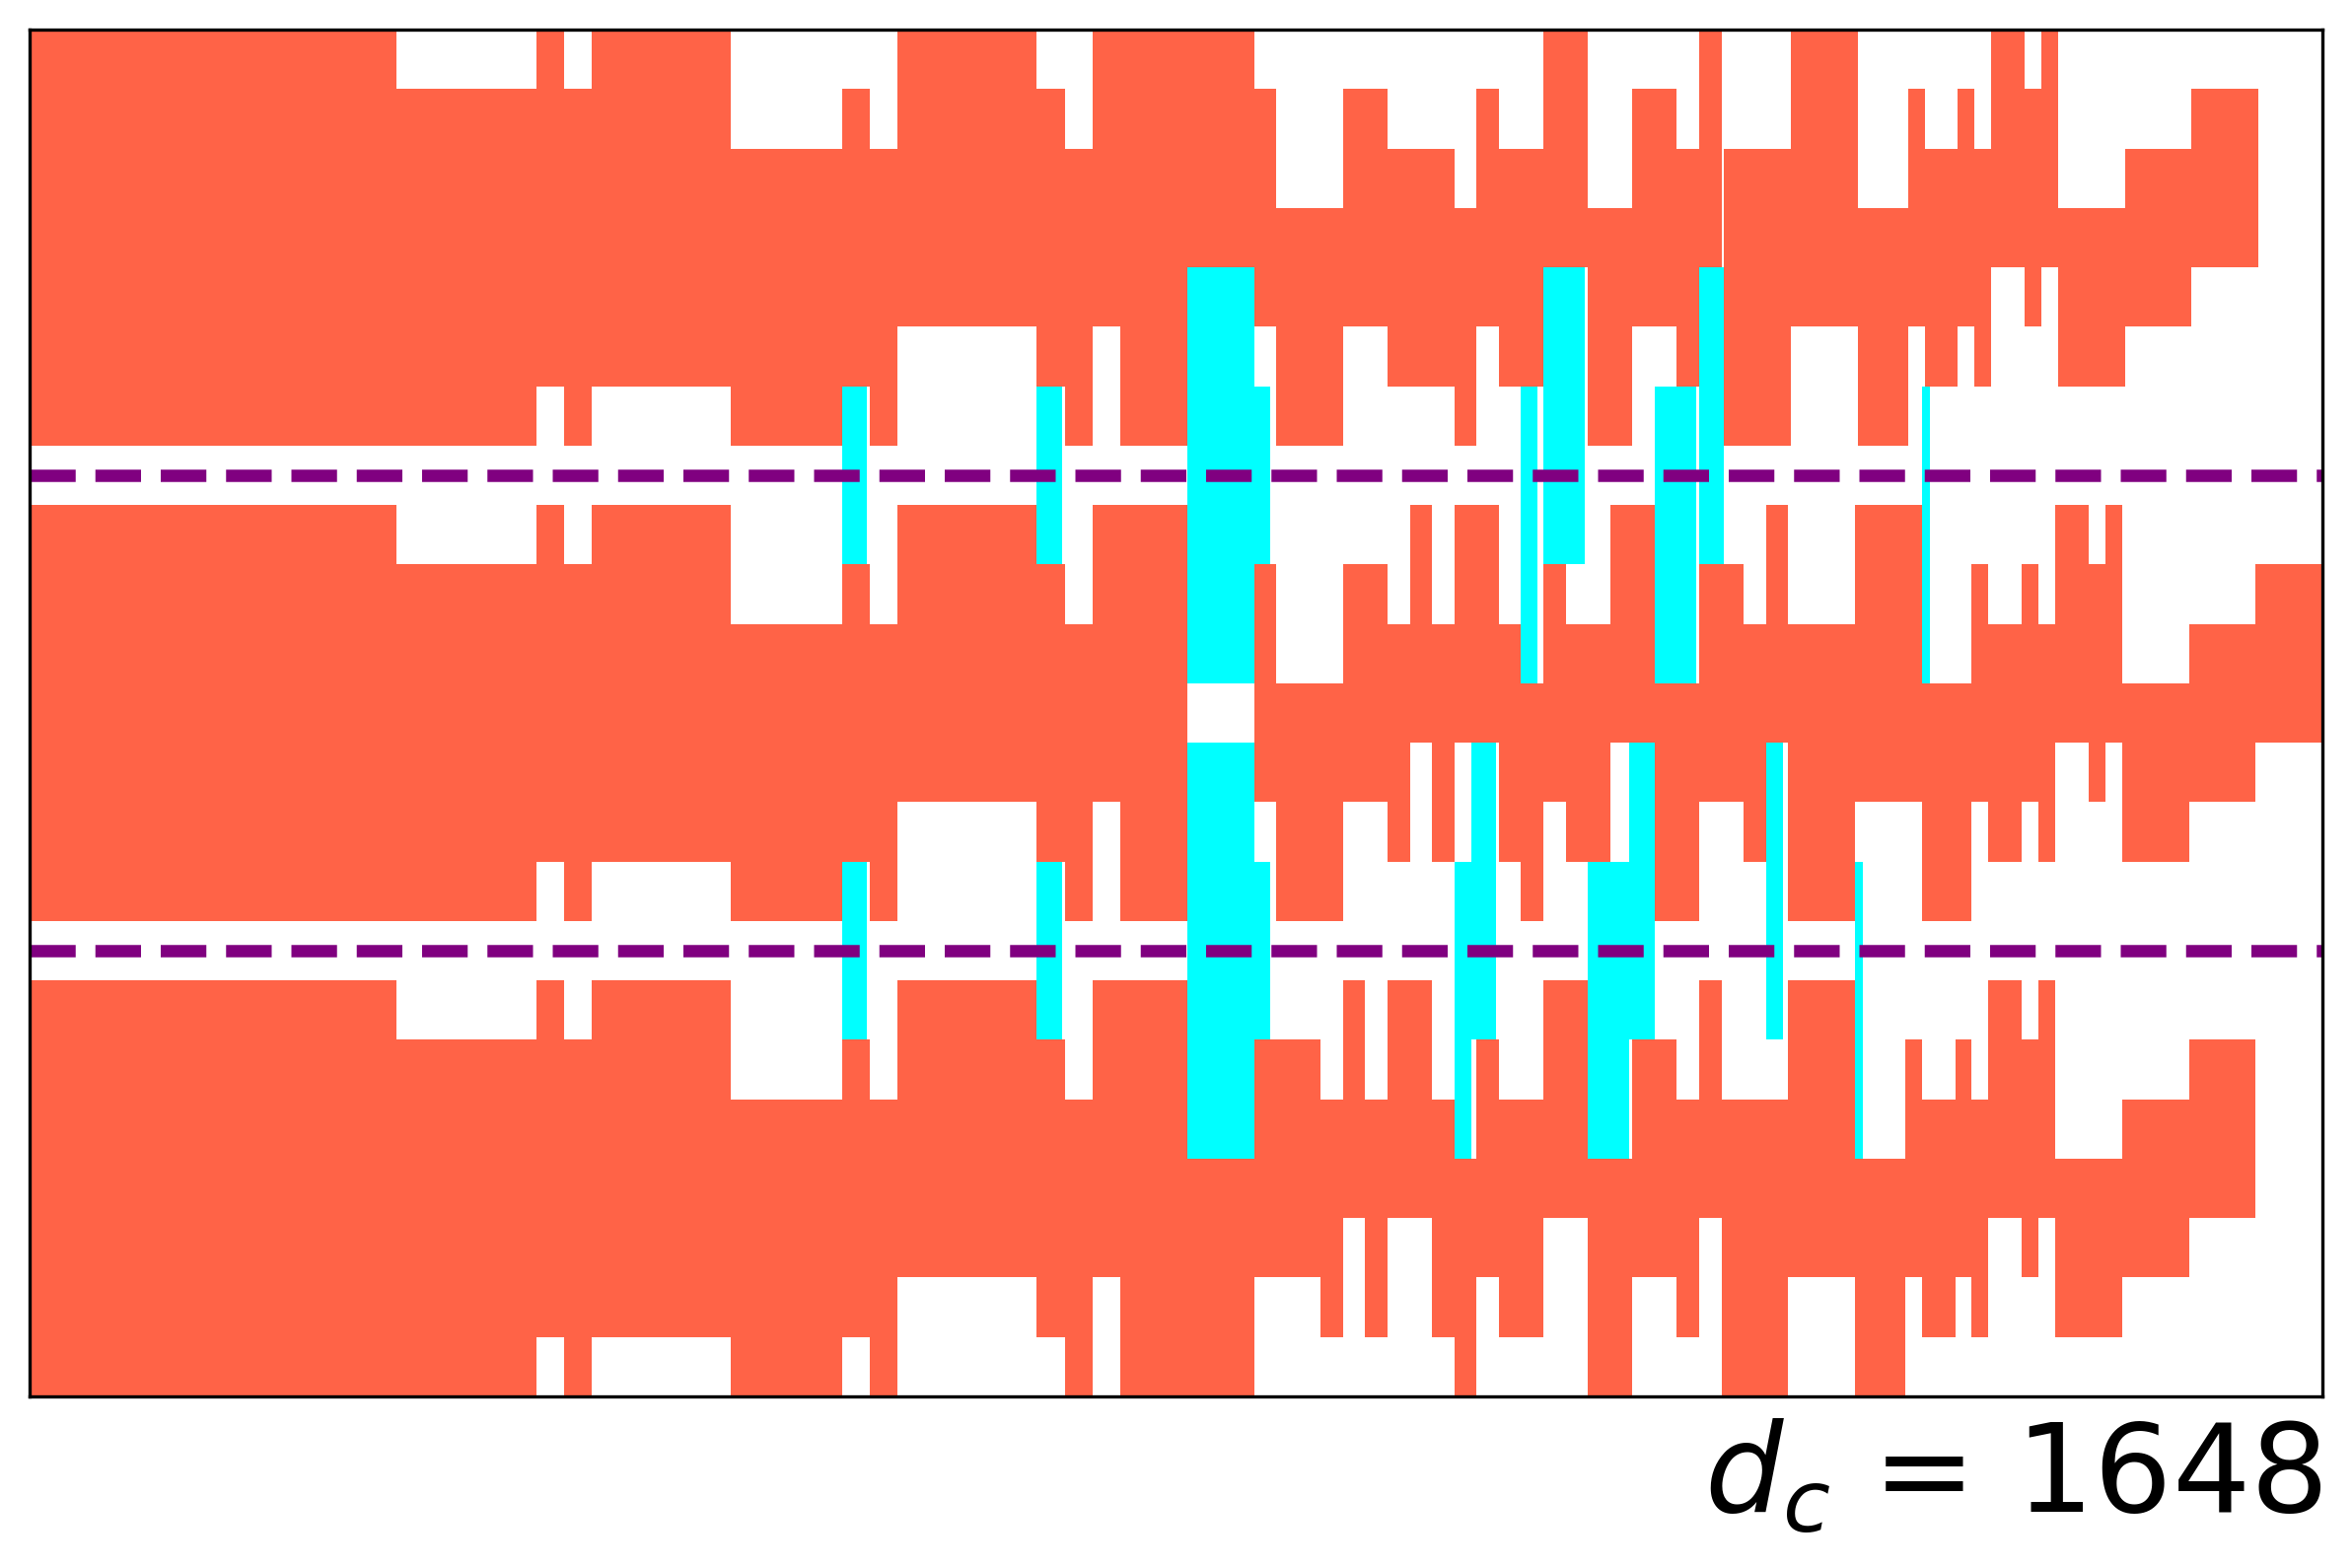

[]
122
Construct based on unplaced tiles
sorted
create complete
Bounding box size: 1808 x 23
Placed tiles: [(0, [[14, 7, 0, 0, 0]]), (14, [[14, 7, 0, 0, 0]]), (28, [[14, 7, 0, 0, 0]]), (42, [[14, 7, 0, 0, 0]]), (56, [[14, 7, 0, 0, 0]]), (70, [[14, 7, 0, 0, 0]]), (84, [[14, 7, 0, 0, 0]]), (98, [[14, 7, 0, 0, 0]]), (112, [[14, 7, 0, 0, 0]]), (126, [[14, 7, 0, 0, 0]]), (140, [[14, 7, 0, 0, 0]]), (154, [[14, 7, 0, 0, 0]]), (168, [[14, 7, 0, 0, 0]]), (182, [[14, 7, 0, 0, 0]]), (196, [[14, 7, 0, 0, 0]]), (210, [[14, 7, 0, 0, 0]]), (0, [[14, 7, 0, 8, 0]]), (14, [[14, 7, 0, 8, 0]]), (28, [[14, 7, 0, 8, 0]]), (42, [[14, 7, 0, 8, 0]]), (56, [[14, 7, 0, 8, 0]]), (70, [[14, 7, 0, 8, 0]]), (84, [[14, 7, 0, 8, 0]]), (98, [[14, 7, 0, 8, 0]]), (112, [[14, 7, 0, 8, 0]]), (126, [[14, 7, 0, 8, 0]]), (140, [[14, 7, 0, 8, 0]]), (154, [[14, 7, 0, 8, 0]]), (168, [[14, 7, 0, 8, 0]]), (182, [[14, 7, 0, 8, 0]]), (196, [[14, 7, 0, 8, 0]]), (210, [[14, 7, 0, 8, 0]]), (0, [[14, 7, 0, 16, 0]]), (14, [[14, 7, 0, 16,

KeyboardInterrupt: 

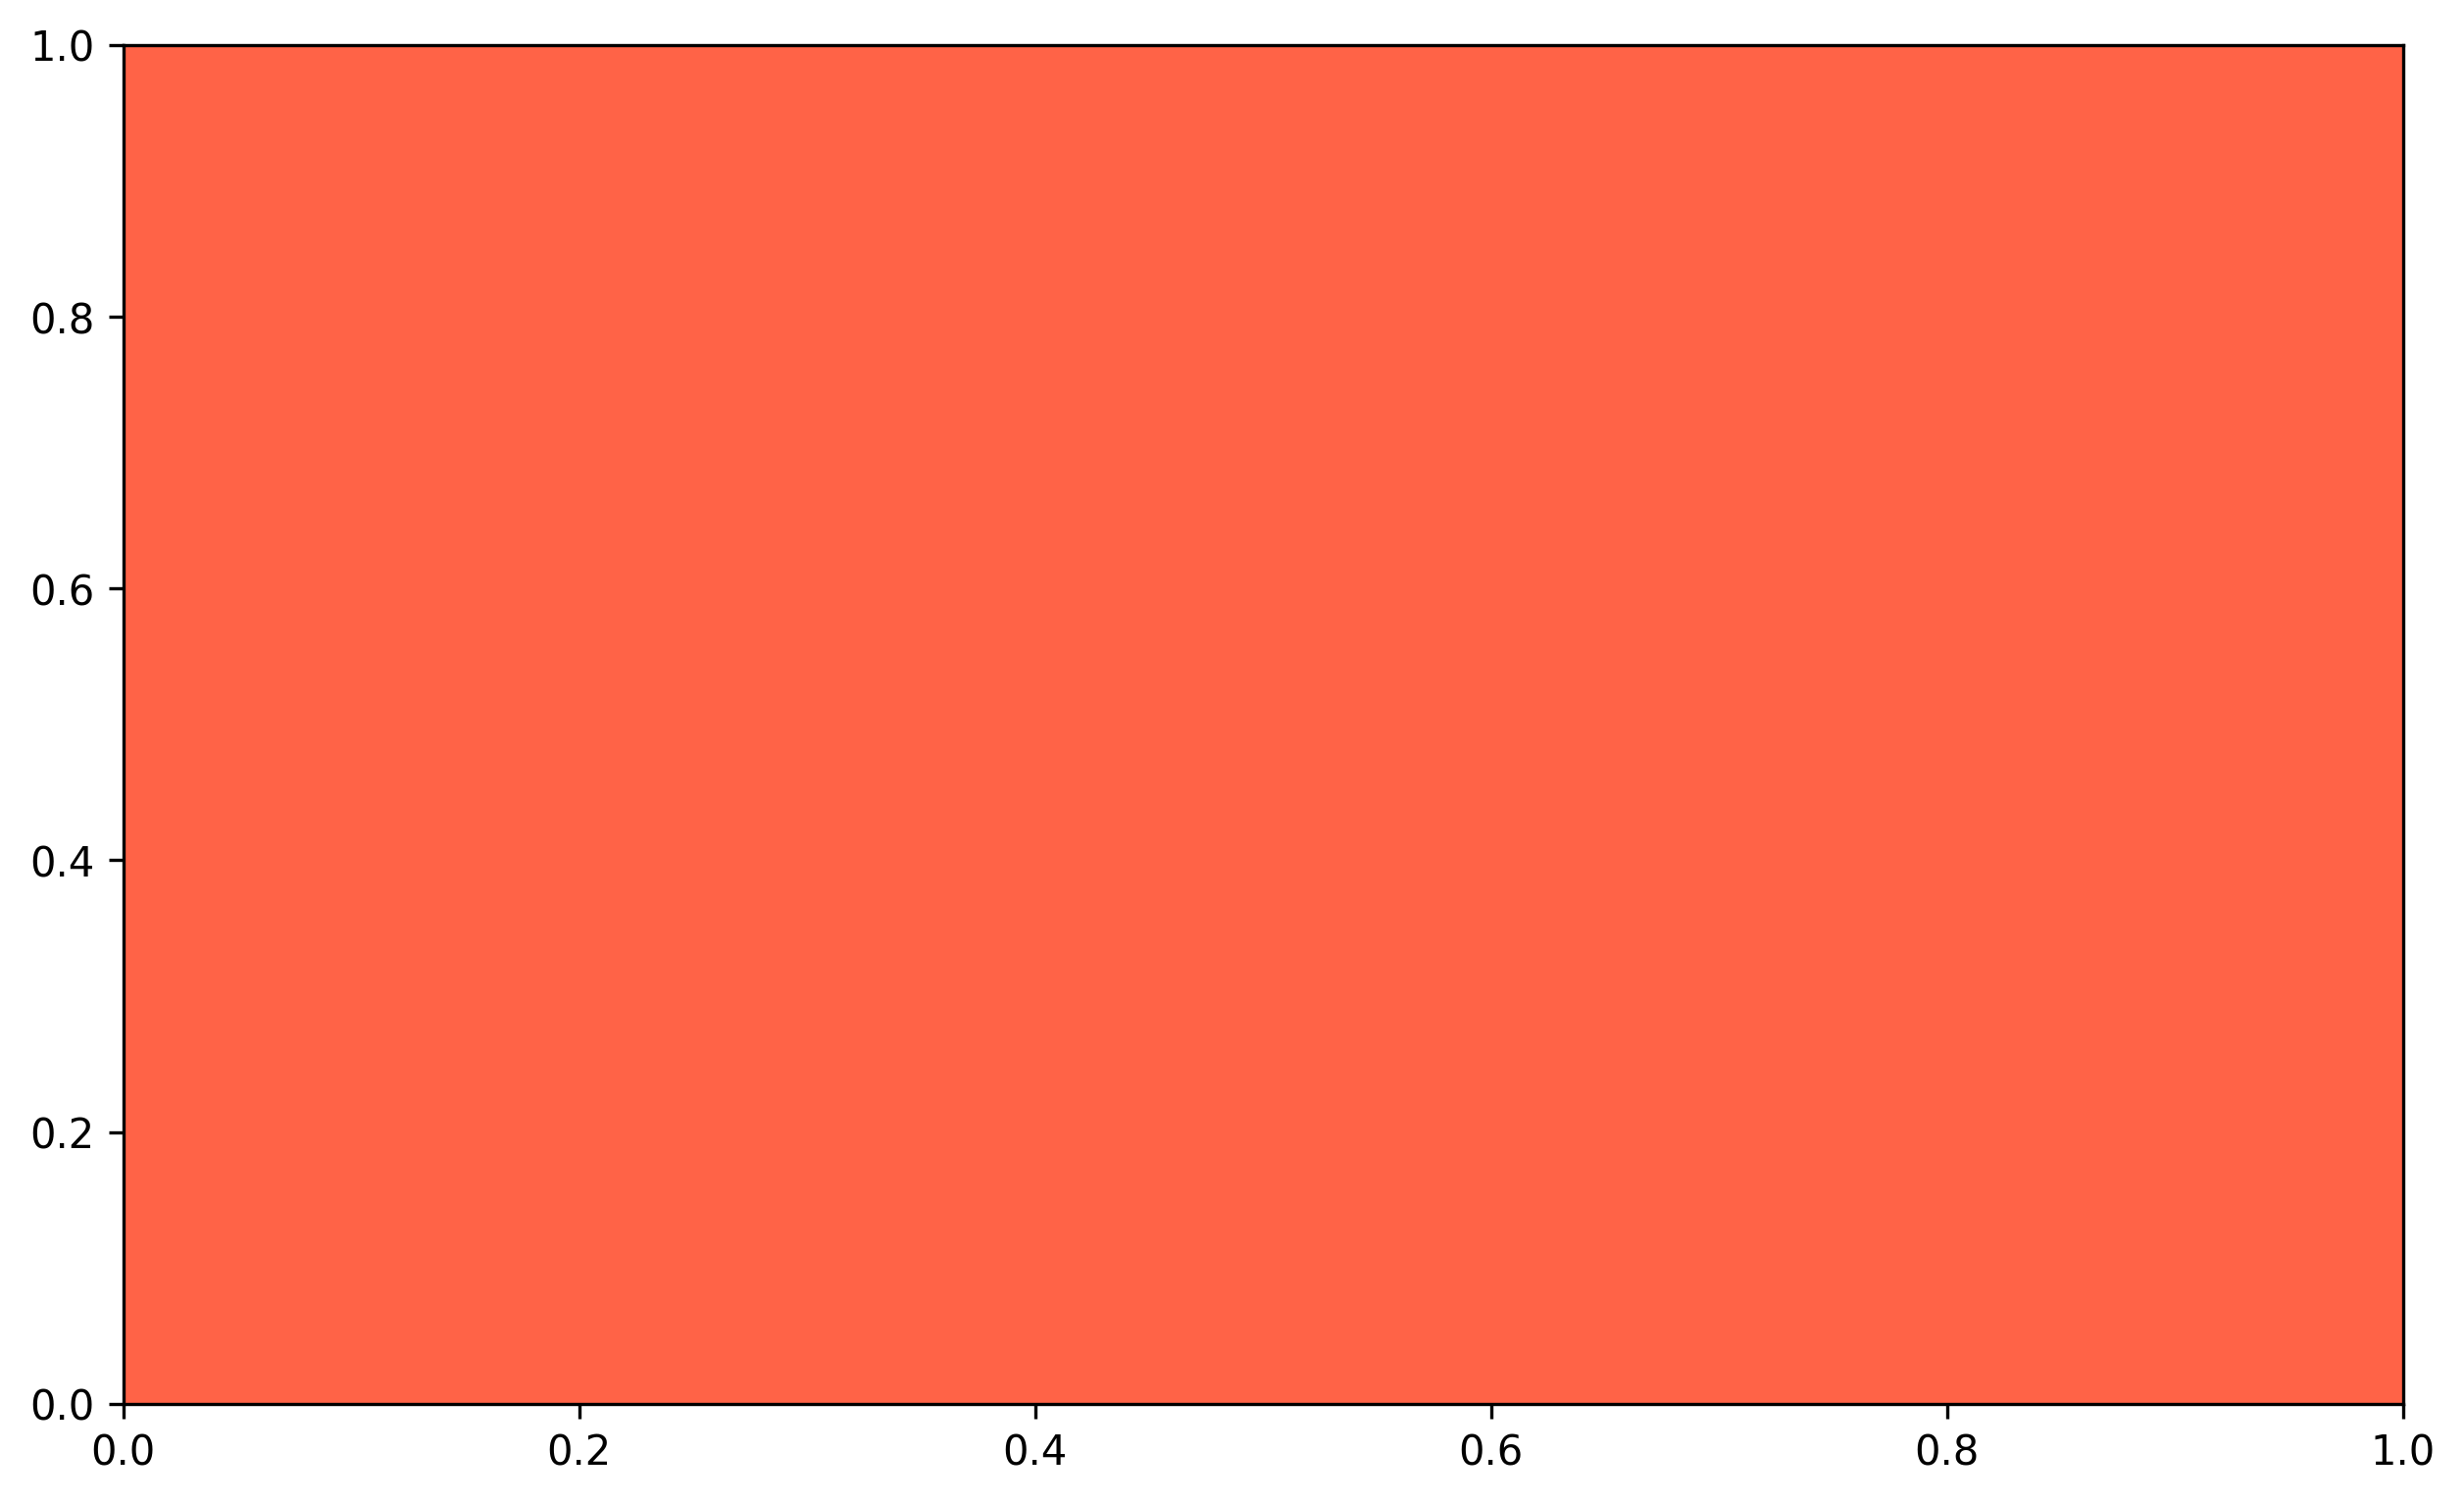

In [8]:
N = 24; f_orbs = (2,2,2,2,2,2)
epsilon_lst = [1e-3, 7e-4, 7e-5]
overlap_lst = []
seam_lst = [8,16]
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    ansatz, excitations,initial_state,hamiltonian = read_data_distance(1.5, epsilon,prehead)
    print(len(excitations))
    excitations = orbital_reordering(excitations, f_orbs)
    if i == 0:
        overlap_lst ==[]
    else:
        _, pre_excitations,_,_ = read_data_distance(1.5, epsilon_lst[i-1],prehead)
        pre_excitations = orbital_reordering(pre_excitations, f_orbs)
        overlap_lst = [sublist for sublist in excitations if sublist not in pre_excitations]
    tiles = create_circuit_tile(excitations, overlap_lst)
    packer = DrawTilePacking(tiles)
    print("create complete")
    width, height, placed_tiles, grid = packer.pack_tiles()
    print(f"Bounding box size: {width} x {height}")
    print("Placed tiles:", placed_tiles)
    packer.draw_packing_overlap(grid,seam_lst,epsilon)
    print(overlap_lst)

In [18]:
def create_excitation(uop, all_g, epsilon):
    excitations = []
    a_index = uop.a_idxs
    i_index = uop.i_idxs
    for [gradient, i] in all_g:
        gradient = abs(gradient)
        if gradient > epsilon:
            cur_a = a_index[i].copy()
            cur_a = cur_a.tolist()
            cur_i = i_index[i].copy()
            cur_i = cur_i.tolist()
            cur_excitation = [cur_a, cur_i]
            excitations.append(cur_excitation)
    return excitations

C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/H_12_cluster/
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[[2, 0], [6, 0]], [[2, 0], [4, 2]], [[2, 0], [6, 1]], [[2, 0], [4, 3]], [[2, 0], [7, 1]], [[2, 0], [5, 3]], [[2, 0], [7, 5]], [[1, 0], [4, 1]], [[3, 0], [4, 3]], [[1, 2], [6, 1]], [[3, 2], [6, 3]], [[1, 0], [5, 0]], [[3, 0], [7, 0]], [[1, 2], [5, 2]], [[3, 2], [7, 2]], [[3, 1], [6, 0]], [[3, 1], [4, 2]], [[3, 1], [6, 4]], [[3, 1], [7, 0]], [[3, 1], [5, 2]], [[3, 1], [7, 1]], [[3, 1], [5, 3]], [[6, 0], [6, 4]], [[4, 2], [6, 4]], [[4, 0], [5, 1]], [[6, 0], [7, 1]], [[6, 0], [5, 3]], [[4, 2], [7, 1]], [[4, 2], [5, 3]], [[6, 2], [7, 3]], [[6, 0], [7, 5]], [[4, 2], [7, 5]], [[4, 1], [5, 4]], [[6, 1], [5, 6]], [[4, 3], [7, 4]], [[6, 3], [7, 6]], [[6, 1], [7, 5]], [[4, 3], [7, 5]], [[6, 4], [7, 0]], [[6, 4], [5, 2]], [[6, 4], [7, 1]], [[6, 4], [5, 3]], [[5, 0], [5, 4]], [[7, 0], [7, 4]], [[5, 2], [5, 6]], [[7, 2], [7, 6]], [[7, 1], [7, 5]], [

C:\Users\24835\AppData\Local\Temp\ipykernel_32148\4002606397.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(self.placed_tiles))


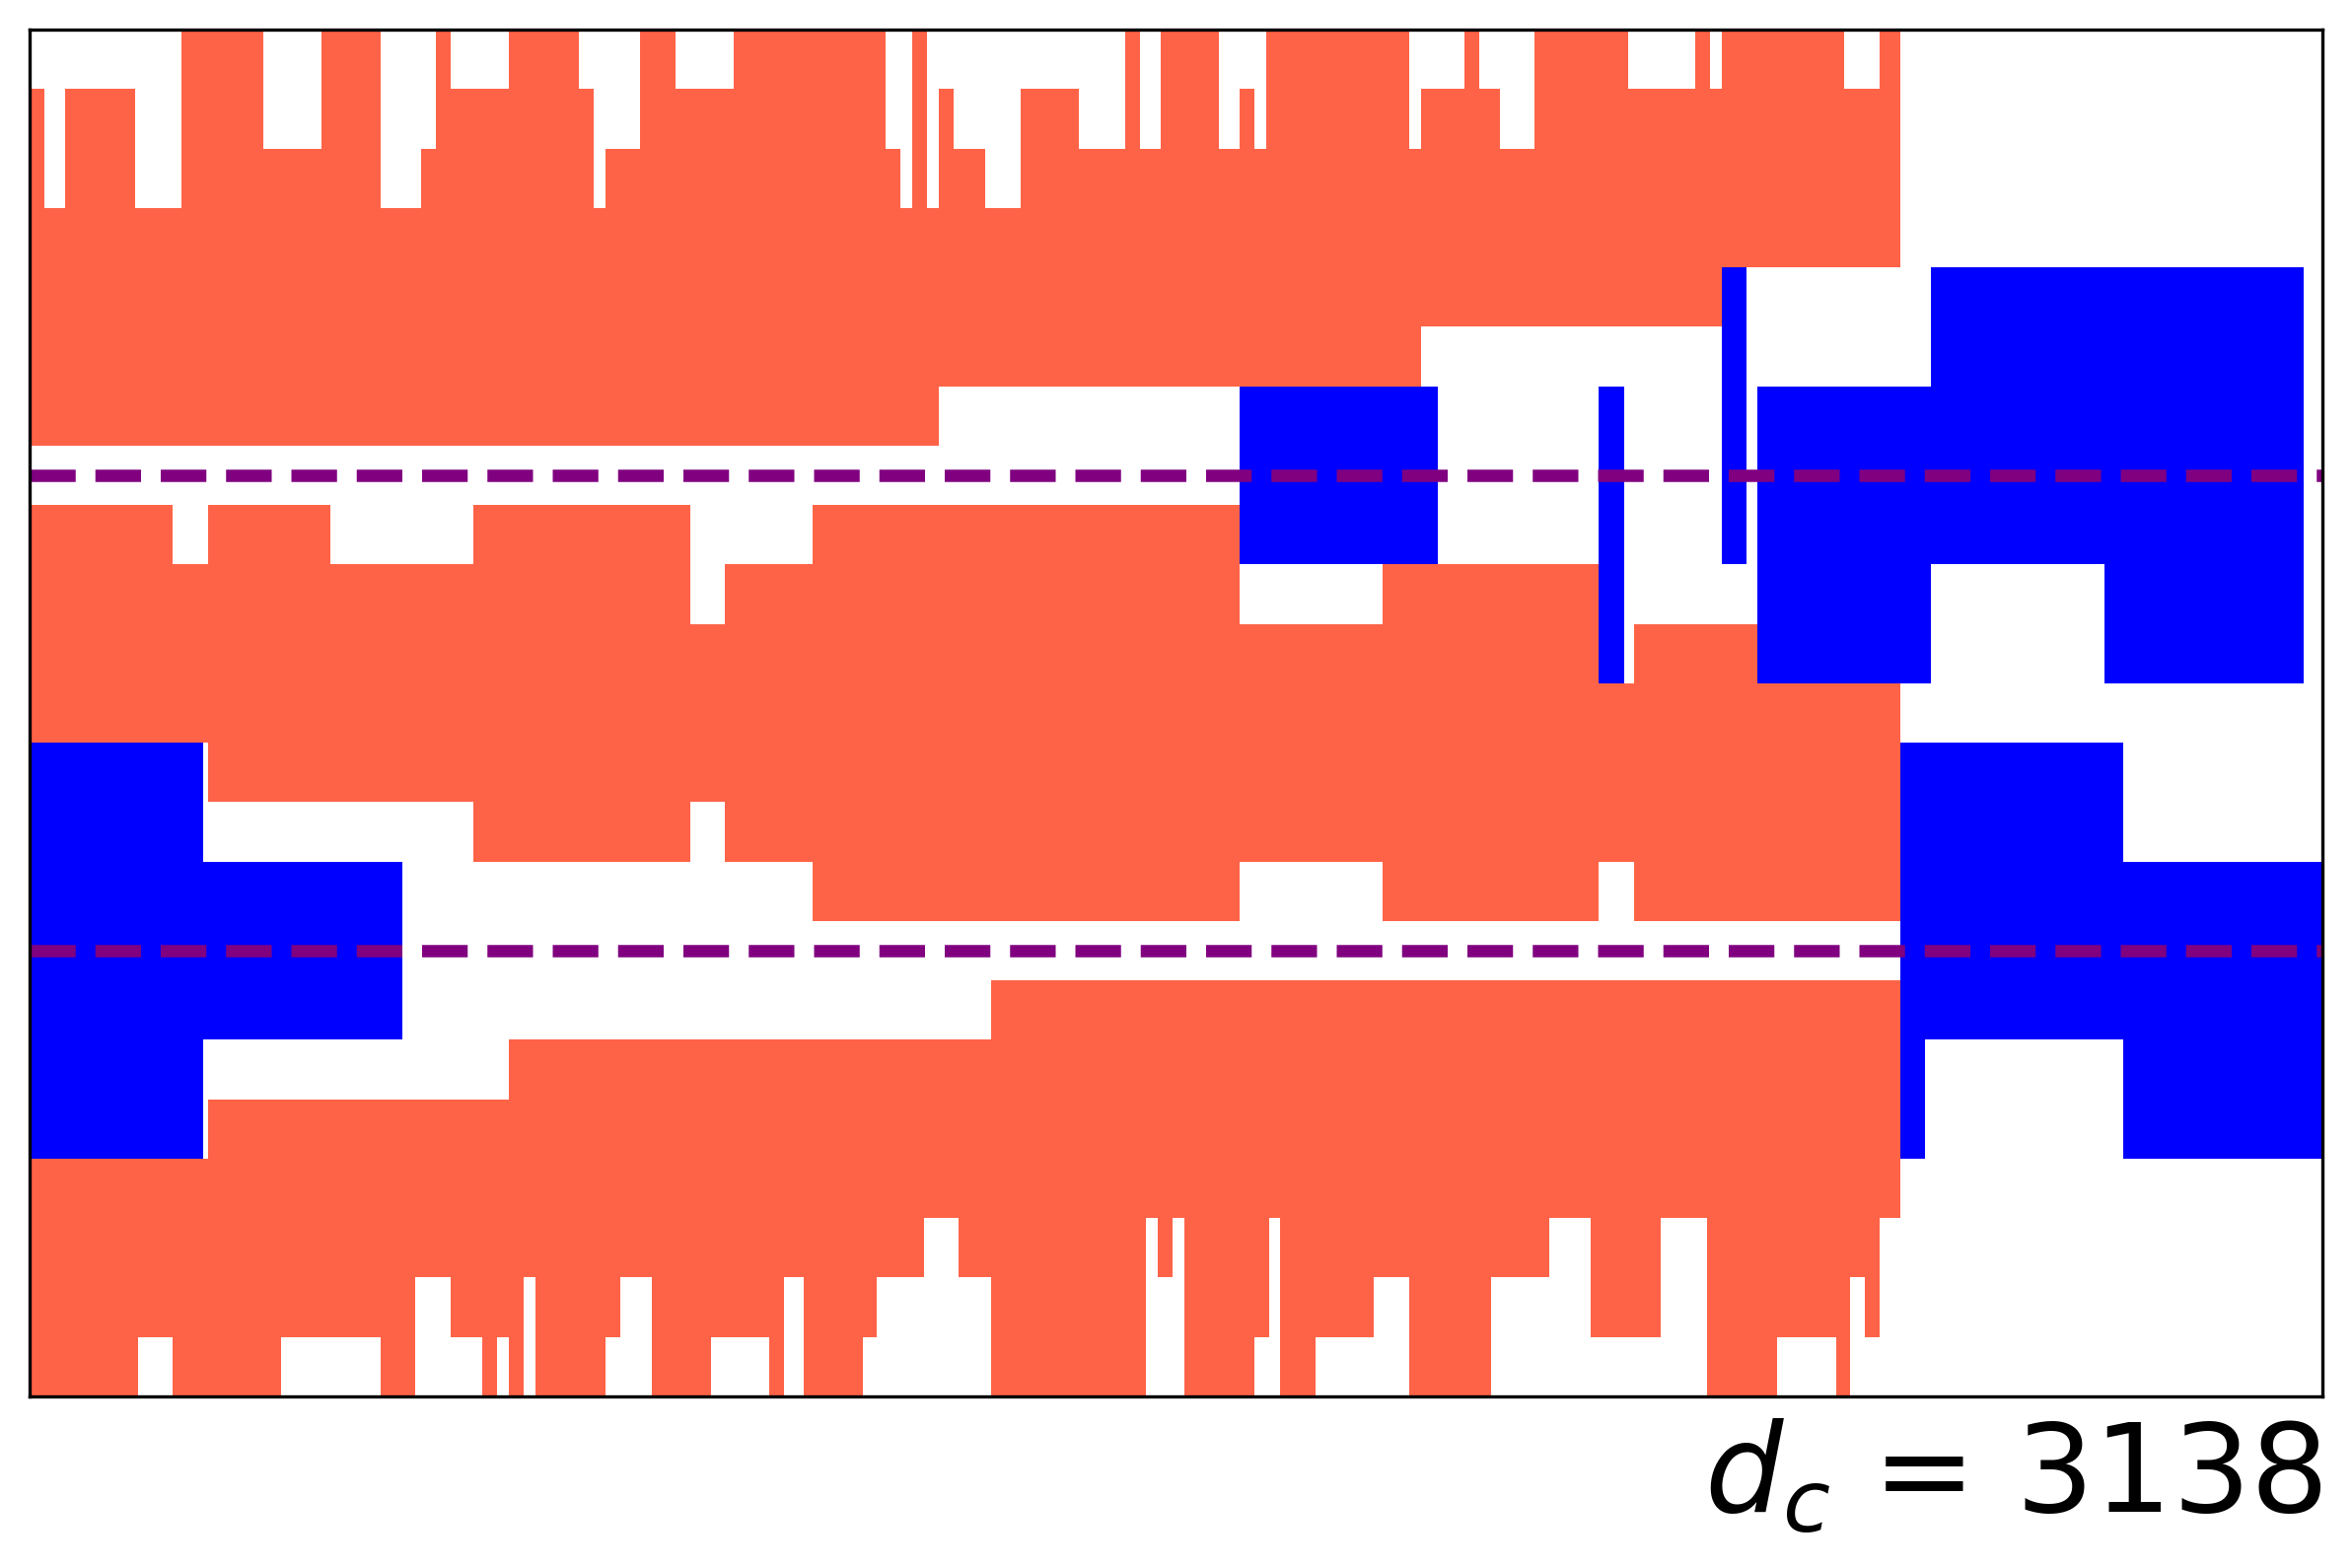

[]
[[[2, 0], [6, 0]], [[2, 0], [4, 2]], [[2, 0], [6, 1]], [[2, 0], [4, 3]], [[2, 0], [7, 1]], [[2, 0], [5, 3]], [[2, 0], [7, 5]], [[1, 0], [4, 1]], [[3, 0], [4, 3]], [[1, 2], [6, 1]], [[3, 2], [6, 3]], [[1, 0], [5, 0]], [[3, 0], [7, 0]], [[1, 2], [5, 2]], [[3, 2], [7, 2]], [[3, 1], [6, 0]], [[3, 1], [4, 2]], [[3, 1], [6, 4]], [[3, 1], [7, 0]], [[3, 1], [5, 2]], [[3, 1], [7, 1]], [[3, 1], [5, 3]], [[4, 0], [4, 1]], [[6, 0], [6, 1]], [[4, 2], [4, 3]], [[6, 2], [6, 3]], [[6, 0], [6, 4]], [[4, 2], [6, 4]], [[4, 0], [5, 0]], [[6, 0], [7, 0]], [[4, 2], [5, 2]], [[6, 2], [7, 2]], [[4, 0], [5, 1]], [[6, 0], [7, 1]], [[6, 0], [5, 3]], [[4, 2], [7, 1]], [[4, 2], [5, 3]], [[6, 2], [7, 3]], [[6, 0], [7, 5]], [[4, 2], [7, 5]], [[4, 1], [5, 1]], [[6, 1], [7, 1]], [[4, 3], [5, 3]], [[6, 3], [7, 3]], [[4, 1], [5, 4]], [[6, 1], [5, 6]], [[4, 3], [7, 4]], [[6, 3], [7, 6]], [[6, 1], [7, 5]], [[4, 3], [7, 5]], [[6, 4], [7, 0]], [[6, 4], [5, 2]], [[6, 4], [7, 1]], [[6, 4], [5, 3]], [[5, 0], [5, 1]], [[7, 0

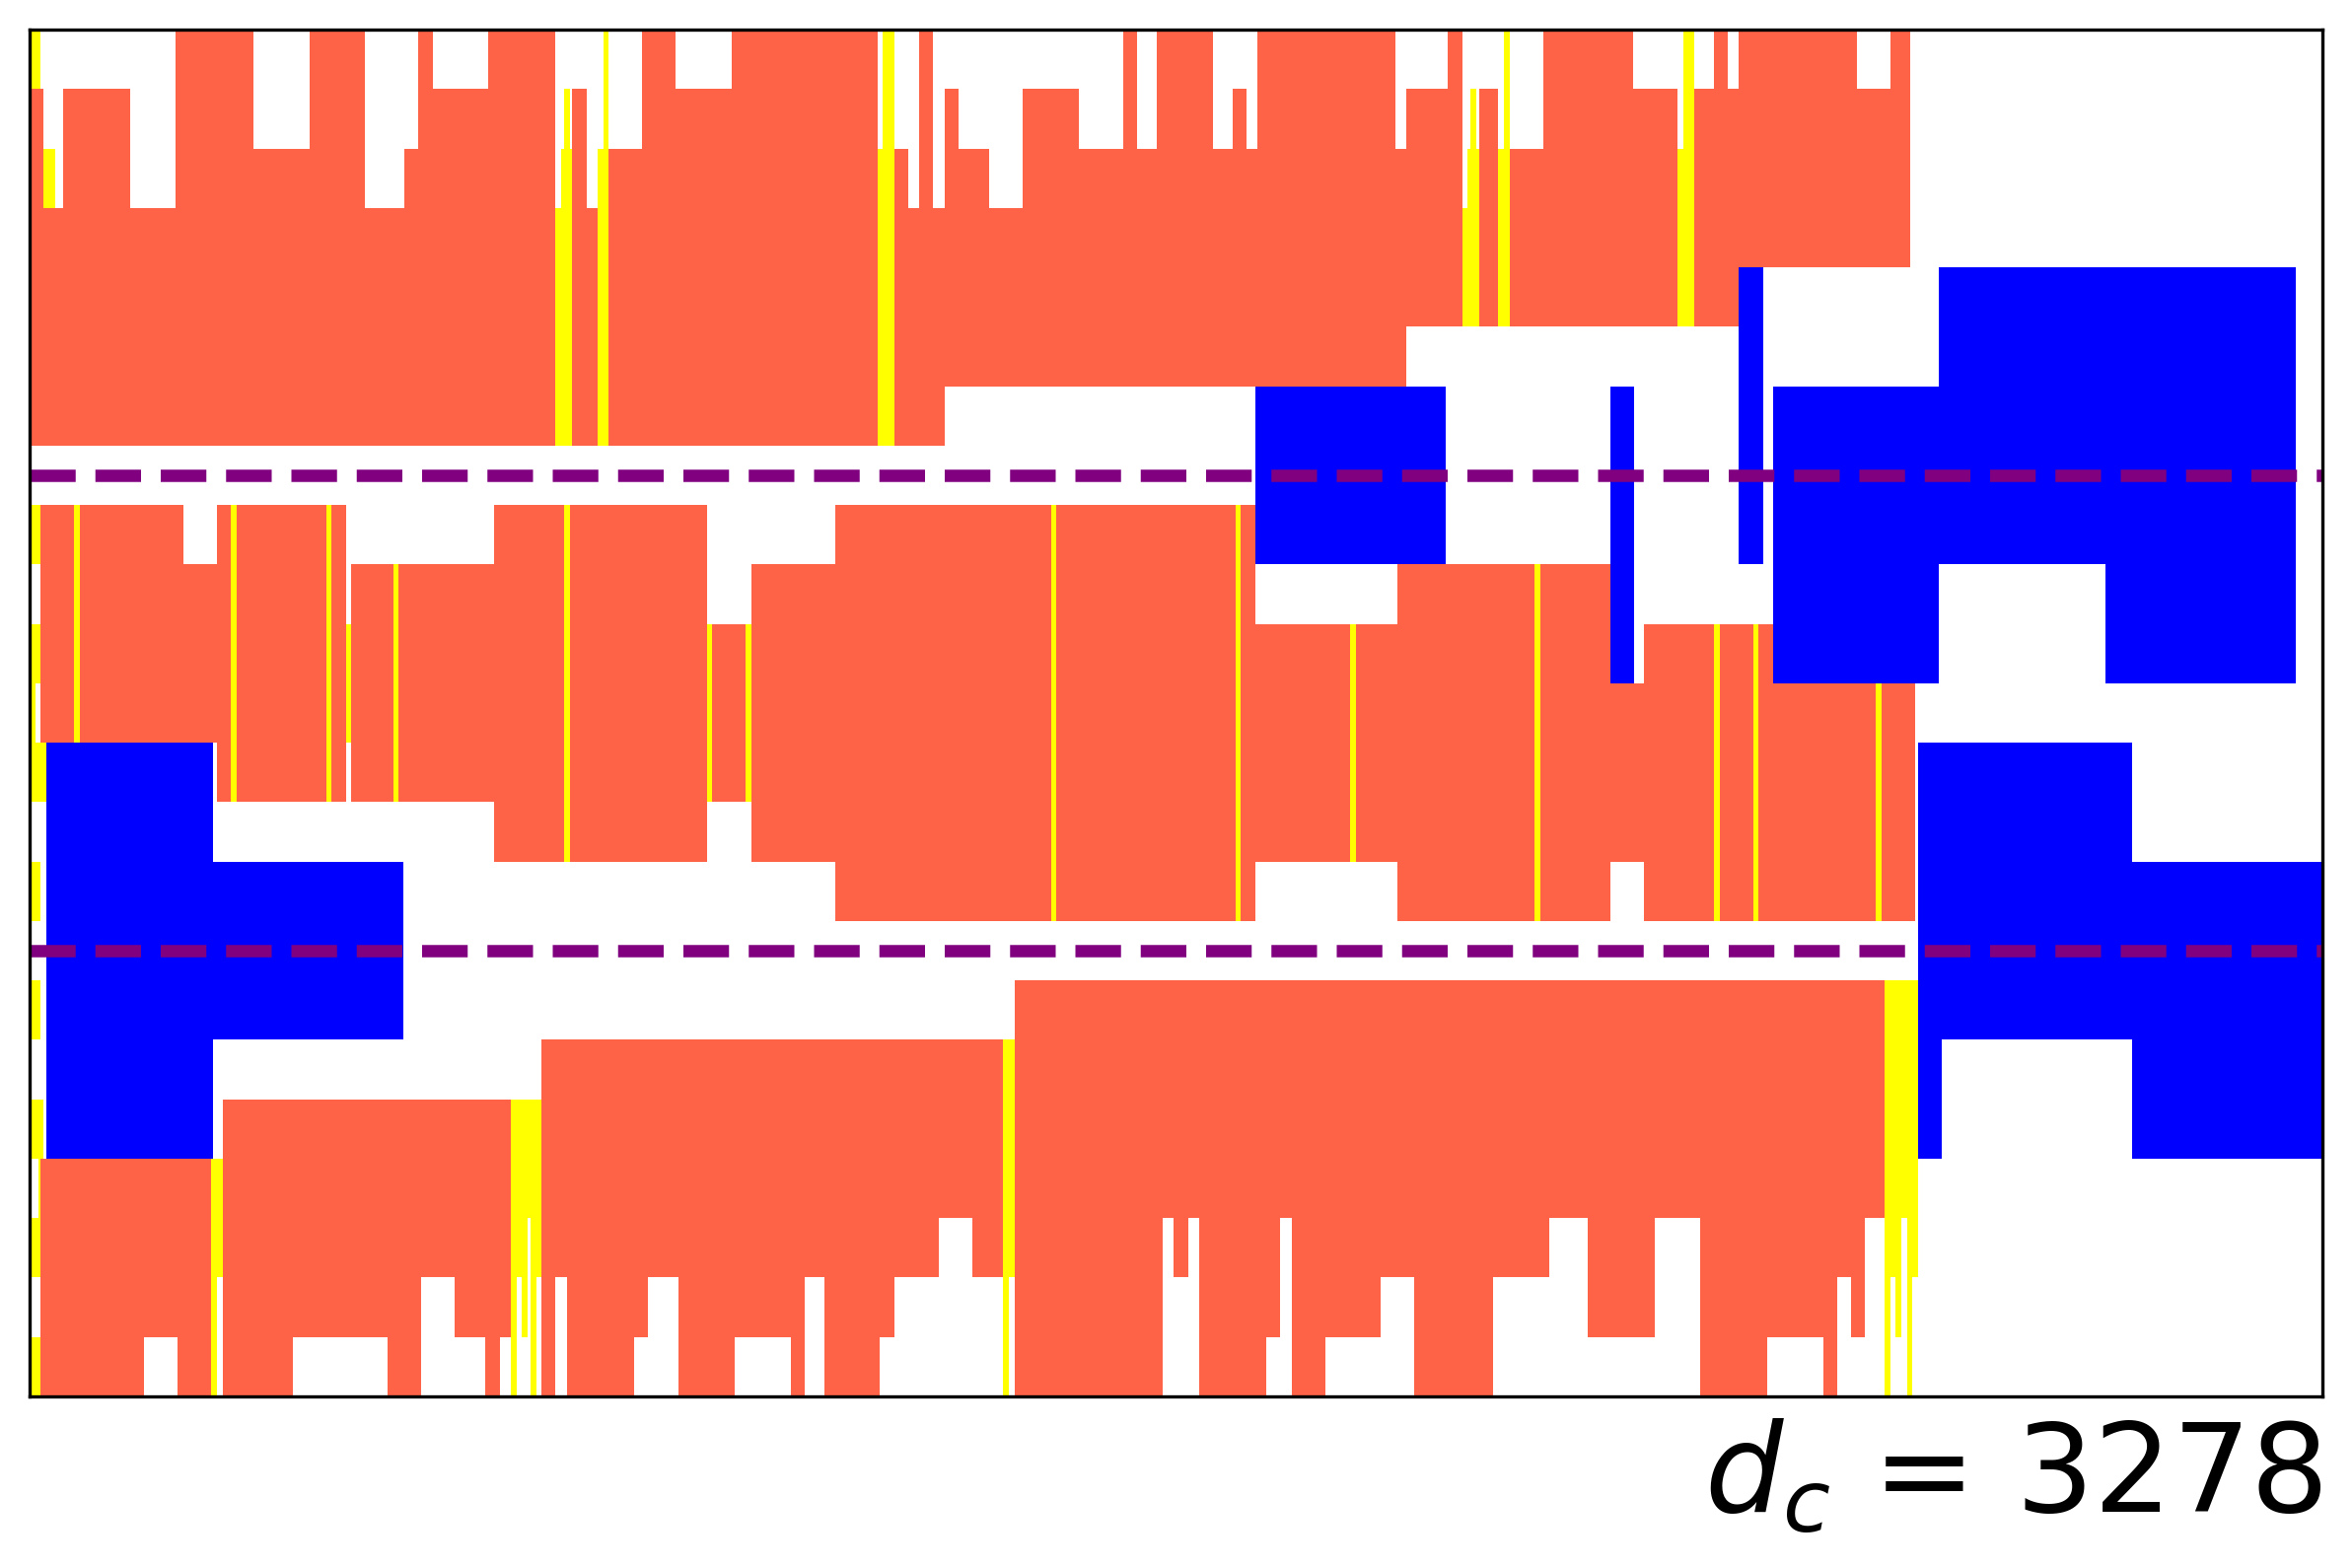

[[[0, 4], [1, 4]], [[0, 6], [1, 6]], [[2, 4], [3, 4]], [[2, 6], [3, 6]], [[0, 4], [0, 5]], [[0, 6], [0, 7]], [[2, 4], [2, 5]], [[2, 6], [2, 7]], [[1, 4], [1, 5]], [[1, 6], [1, 7]], [[3, 4], [3, 5]], [[3, 6], [3, 7]], [[0, 5], [1, 5]], [[0, 7], [1, 7]], [[2, 5], [3, 5]], [[2, 7], [3, 7]], [[8, 12], [9, 12]], [[8, 14], [9, 14]], [[10, 12], [11, 12]], [[10, 14], [11, 14]], [[8, 12], [8, 13]], [[8, 14], [8, 15]], [[10, 12], [10, 13]], [[10, 14], [10, 15]], [[9, 12], [9, 13]], [[9, 14], [9, 15]], [[11, 12], [11, 13]], [[11, 14], [11, 15]], [[8, 13], [9, 13]], [[8, 15], [9, 15]], [[10, 13], [11, 13]], [[10, 15], [11, 15]], [[16, 20], [17, 20]], [[16, 22], [17, 22]], [[18, 20], [19, 20]], [[18, 22], [19, 22]], [[16, 20], [16, 21]], [[16, 22], [16, 23]], [[18, 20], [18, 21]], [[18, 22], [18, 23]], [[17, 20], [17, 21]], [[17, 22], [17, 23]], [[19, 20], [19, 21]], [[19, 22], [19, 23]], [[16, 21], [17, 21]], [[16, 23], [17, 23]], [[18, 21], [19, 21]], [[18, 23], [19, 23]]]
[[[4], [1]], [[6], [3]]

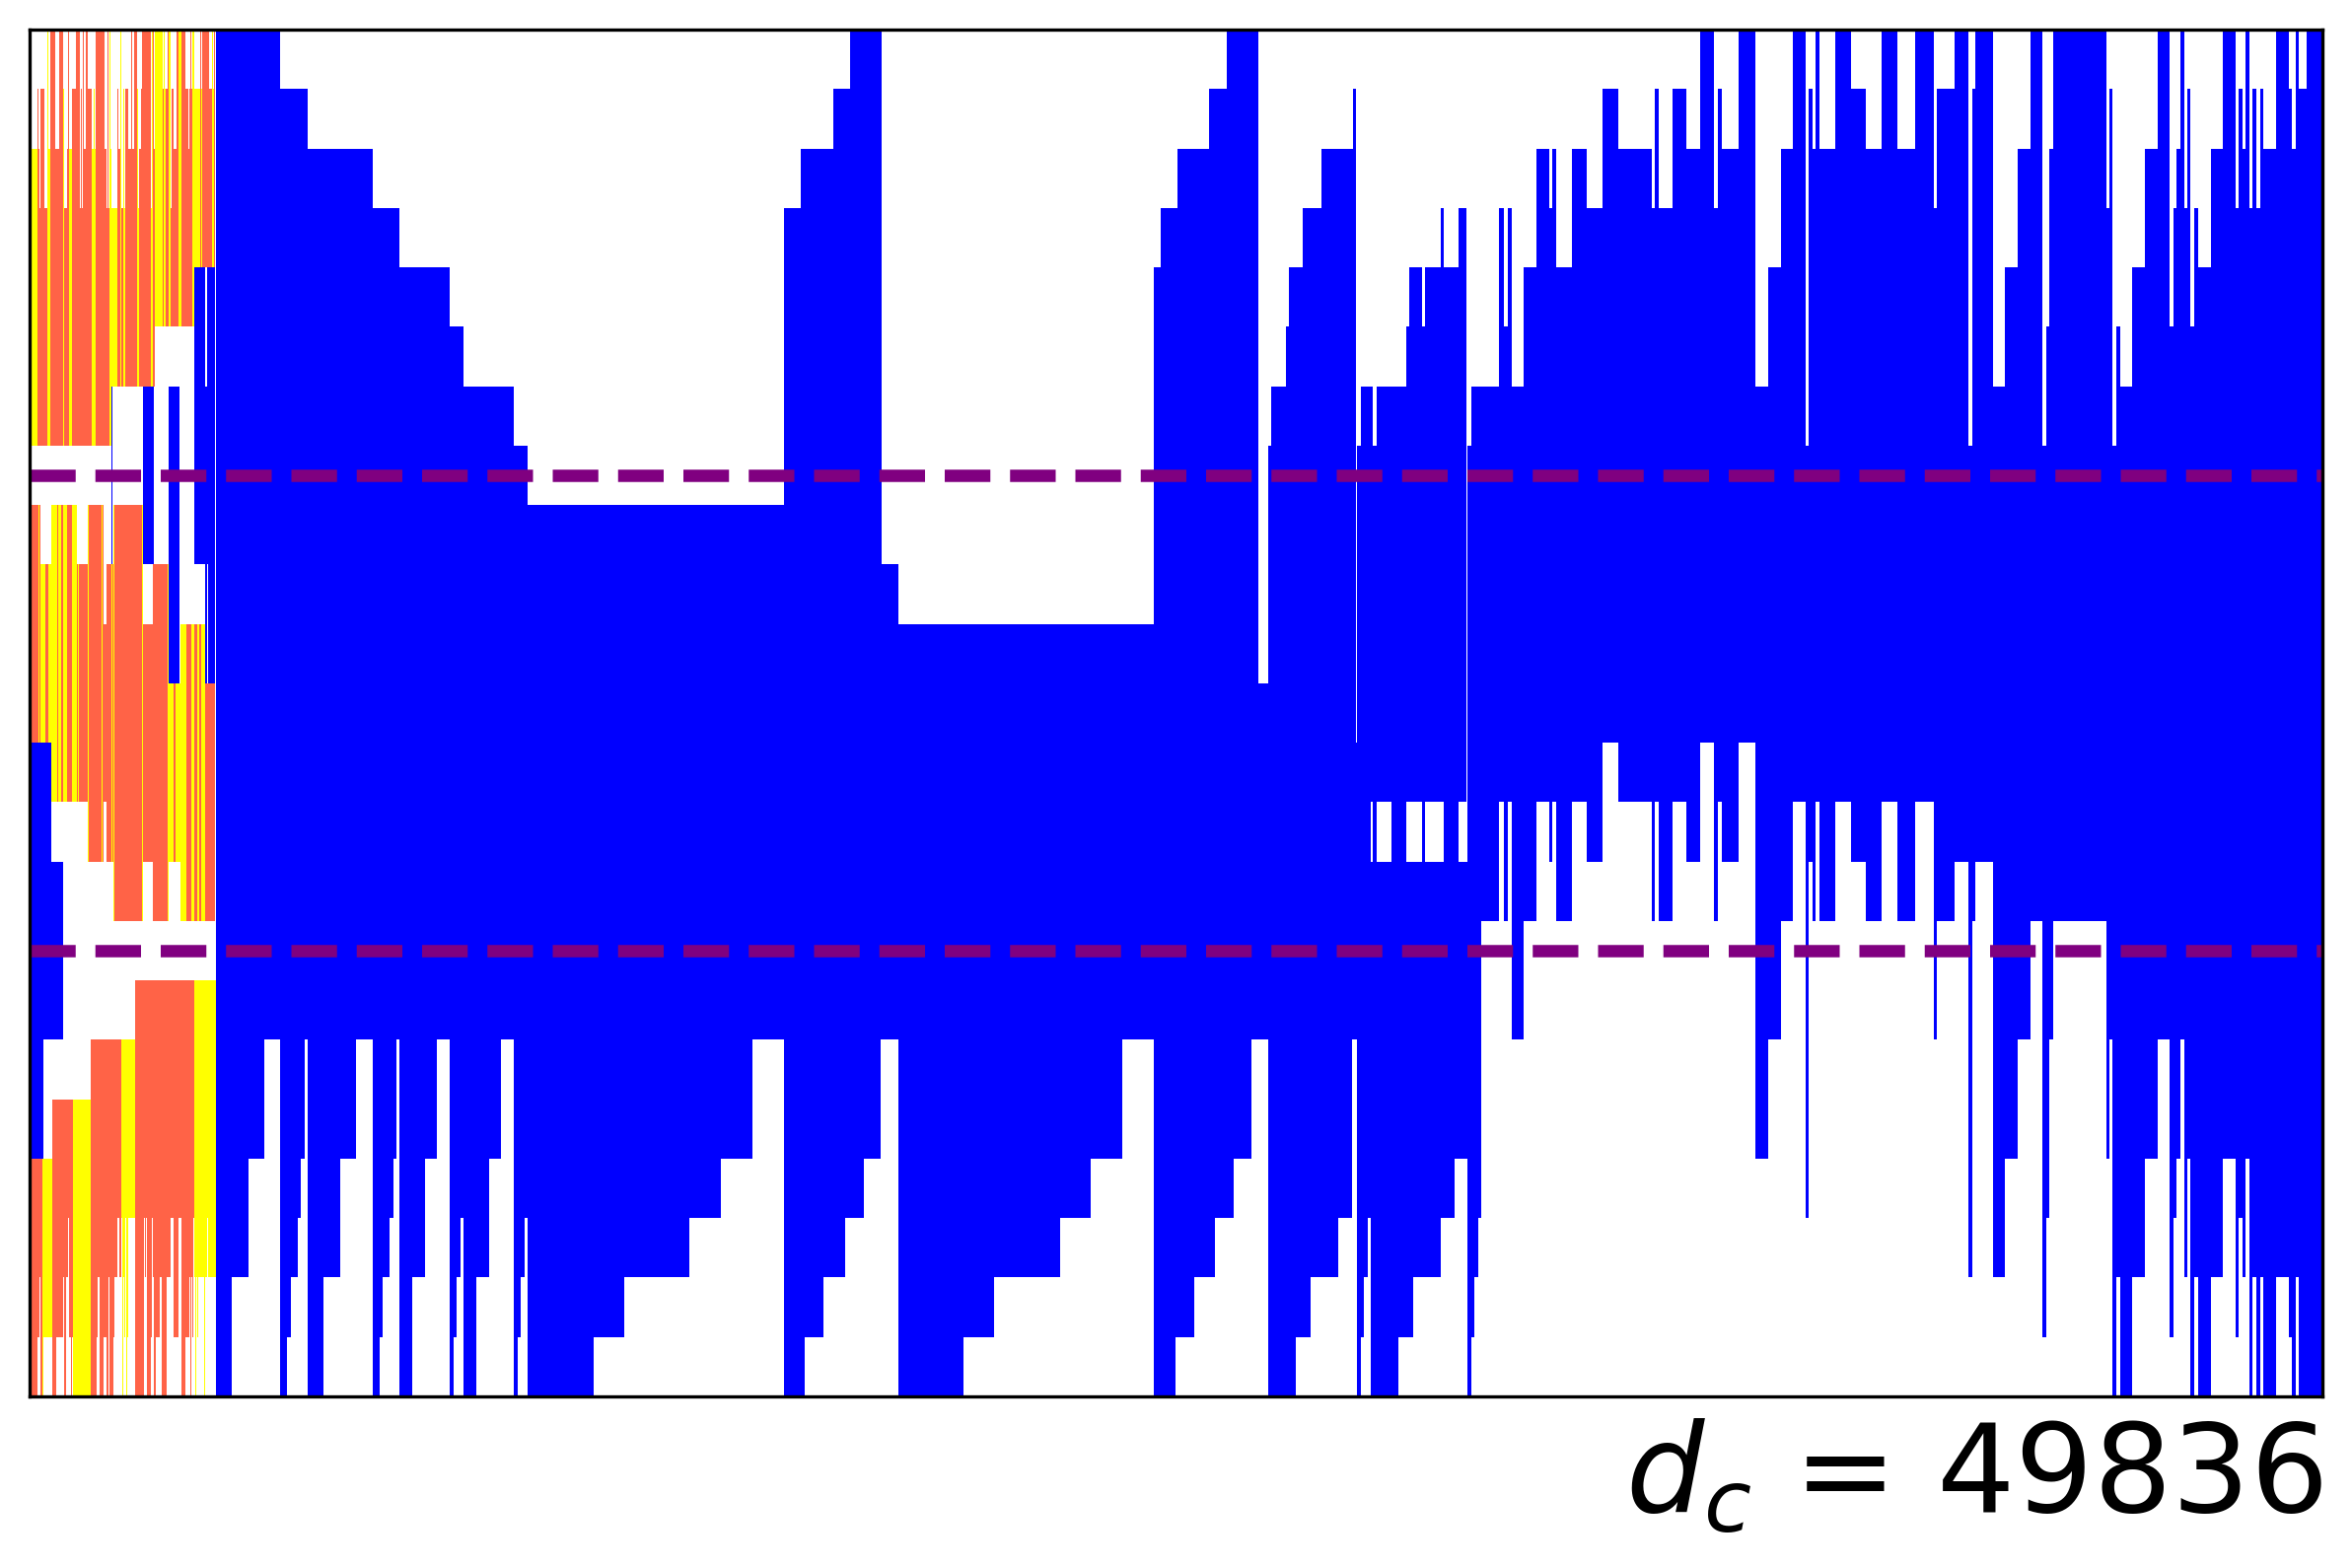

[[[4], [1]], [[6], [3]], [[5], [0]], [[7], [2]], [[12], [9]], [[14], [11]], [[13], [8]], [[15], [10]], [[20], [17]], [[22], [19]], [[21], [16]], [[23], [18]], [[0, 2], [0, 7]], [[0, 2], [2, 5]], [[0, 1], [0, 4]], [[0, 3], [0, 6]], [[1, 2], [2, 4]], [[2, 3], [2, 6]], [[0, 1], [1, 5]], [[0, 3], [3, 5]], [[1, 2], [1, 7]], [[2, 3], [3, 7]], [[1, 3], [1, 6]], [[1, 3], [3, 4]], [[0, 4], [4, 5]], [[0, 6], [5, 6]], [[2, 4], [4, 7]], [[2, 6], [6, 7]], [[1, 6], [4, 6]], [[3, 4], [4, 6]], [[0, 7], [5, 7]], [[2, 5], [5, 7]], [[1, 5], [4, 5]], [[1, 7], [4, 7]], [[3, 5], [5, 6]], [[3, 7], [6, 7]], [[0, 8], [5, 8]], [[0, 10], [5, 10]], [[2, 8], [7, 8]], [[2, 10], [7, 10]], [[0, 8], [1, 9]], [[0, 10], [1, 11]], [[2, 8], [3, 9]], [[2, 10], [3, 11]], [[0, 8], [5, 9]], [[0, 10], [5, 11]], [[2, 8], [7, 9]], [[2, 10], [7, 11]], [[0, 8], [0, 13]], [[0, 10], [0, 15]], [[2, 8], [2, 13]], [[2, 10], [2, 15]], [[0, 8], [1, 13]], [[0, 10], [1, 15]], [[2, 8], [3, 13]], [[2, 10], [3, 15]], [[0, 8], [5, 13]], [[0, 1

In [23]:
prehead ="C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/H_12_cluster/"

N = 24; f_orbs = (2,2,2,2,2,2)
epsilon_lst = [8e-4, 6e-4, 2e-5]
overlap_lst = []
seam_lst = [8,16]
ratio = 15
read_epsilon = 1.0
distance = 3.0
print(prehead)
uop, all_g = read_uop(distance, read_epsilon, prehead)
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    excitations = create_excitation(uop, all_g, epsilon)
    excitations = orbital_reordering(excitations, f_orbs)
    print(excitations)
    if i == 0:
        overlap_lst ==[]
    else:
        pre_excitations = create_excitation(uop, all_g, epsilon_lst[i-1])
        pre_excitations = orbital_reordering(pre_excitations, f_orbs)
        overlap_lst = [sublist for sublist in excitations if sublist not in pre_excitations]
    
    tiles = create_circuit_tile(excitations, overlap_lst)
    post_tiles = tiles
    post_tiles = process_tiles(tiles, ratio, seam_lst)
    packer = DrawTilePacking(post_tiles,True)

    print("create complete")
    width, height, placed_tiles, grid = packer.pack_tiles()
    print(f"Bounding box size: {width} x {height}")
    print("Placed tiles:", placed_tiles)
    packer.draw_packing_overlap(grid,seam_lst,epsilon, inter_color = "blue", new_inter_color="blue")
    print(overlap_lst)

In [ ]:
N = 24; f_orbs = (2,2,2,2,2,2)
epsilon_lst = [1e-3, 7e-4, 1e-4]
overlap_lst = []
seam_lst = [8,16]
ratio = 1
print(prehead)
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    ansatz, excitations,initial_state,hamiltonian = read_data_distance(1.5, epsilon,prehead)
    excitations = orbital_reordering(excitations, f_orbs)
    if i == 0:
        overlap_lst ==[]
    else:
        _, pre_excitations,_,_ = read_data_distance(1.5, epsilon_lst[i-1],prehead)
        pre_excitations = orbital_reordering(pre_excitations, f_orbs)
        overlap_lst = [sublist for sublist in excitations if sublist not in pre_excitations]
    tiles = create_circuit_tile(excitations, overlap_lst)
    post_tiles = process_tiles(tiles, ratio, seam_lst)
    
    packer = DrawTilePacking(post_tiles,True)

    print("create complete")
    width, height, placed_tiles, grid = packer.pack_tiles()
    print(f"Bounding box size: {width} x {height}")
    print("Placed tiles:", placed_tiles)
    packer.draw_packing_overlap(grid,seam_lst,epsilon, inter_color = "blue", new_inter_color="blue")
    print(overlap_lst)

C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/H_12_cluster/


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/H_12_cluster/data_e=0.001/ansatz_distance=1.5.qpy'

In [ ]:
N = 24; f_orbs = (2,2,2,2,2,2)
epsilon_lst = [1e-3, 7e-4, 5e-4,3e-4]
overlap_lst = []
seam_lst = [8,16]
ratio = 1
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    ansatz, excitations,initial_state,hamiltonian = read_data_distance(1.5, epsilon,prehead)
    excitations = orbital_reordering(excitations, f_orbs)
    if i == 0:
        overlap_lst ==[]
    else:
        _, pre_excitations,_,_ = read_data_distance(1.5, epsilon_lst[i-1],prehead)
        pre_excitations = orbital_reordering(pre_excitations, f_orbs)
        overlap_lst = [sublist for sublist in excitations if sublist not in pre_excitations]
    tiles = create_circuit_tile(excitations, overlap_lst)
    post_tiles = process_tiles(tiles, ratio, seam_lst)
    
    packer = DrawTilePacking(post_tiles,True)

    print("create complete")
    width, height, placed_tiles, grid = packer.pack_tiles()
    print(f"Bounding box size: {width} x {height}")
    print("Placed tiles:", placed_tiles)
    packer.draw_packing_overlap(grid,seam_lst,epsilon)
    print(overlap_lst)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/H_12_cluster/data_e=0.001/ansatz_distance=1.5.qpy'

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
4 5 7 10
5 6 7 8
0 1 8 9
0 1 10 11
2 3 8 9
2 3 10 11
4 5 8 9
4 5 10 11
6 7 8 9
6 7 10 11
4 9 10 11
6 8 9 11
0 1 12 13
0 1 14 15
2 3 12 13
2 3 14 15
4 5 12 13
4 5 14 15
6 7 12 13
6 7 14 15
12 13 15 18
13 14 15 16
4 5 16 17
4 5 18 19
6 7 16 17
6 7 18 19
8 9 16 17
8 9 18 19
10 11 16 17
10 11 18 19
12 13 16 17
12 13 18 19
14 15 16 17
14 15 18 19
12 17 18 19
14 16 17 19
8 9 20 21
8 9 22 23
10 11 20 21
10 11 22 23
12 13 20 21
12 13 22 23
14 15 20 21
14 15 22 23
hi
320
320
Construct based on unplaced tiles
unsorted
create complete
Bounding box size: 218 x 23
Placed tiles: [(0, [[6, 3, 0, 13, 0]]), (6, [[6, 3, 0, 14, 0]]), (12, [[10, 5, 0, 14, 0]]), (22, [[6, 5, 0, 12, 0]]), (28, [[6, 5, 0, 14, 0]]), (34, [[10, 6, 0, 12, 0]]), (44, [[14, 7, 0, 12, 0]]), (58, [[6, 7, 0, 10, 0]]), (64, [[6, 7, 0, 12, 0]]), (70, [[6, 7, 0, 14, 0]]), (76, [[6, 9, 0, 8, 0]]), (82, [[6, 9, 0, 10, 0]]), (88, [[6, 9, 0, 12, 0]]), (94, [[

C:\Users\24835\AppData\Local\Temp\ipykernel_24820\2046625091.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(self.placed_tiles))


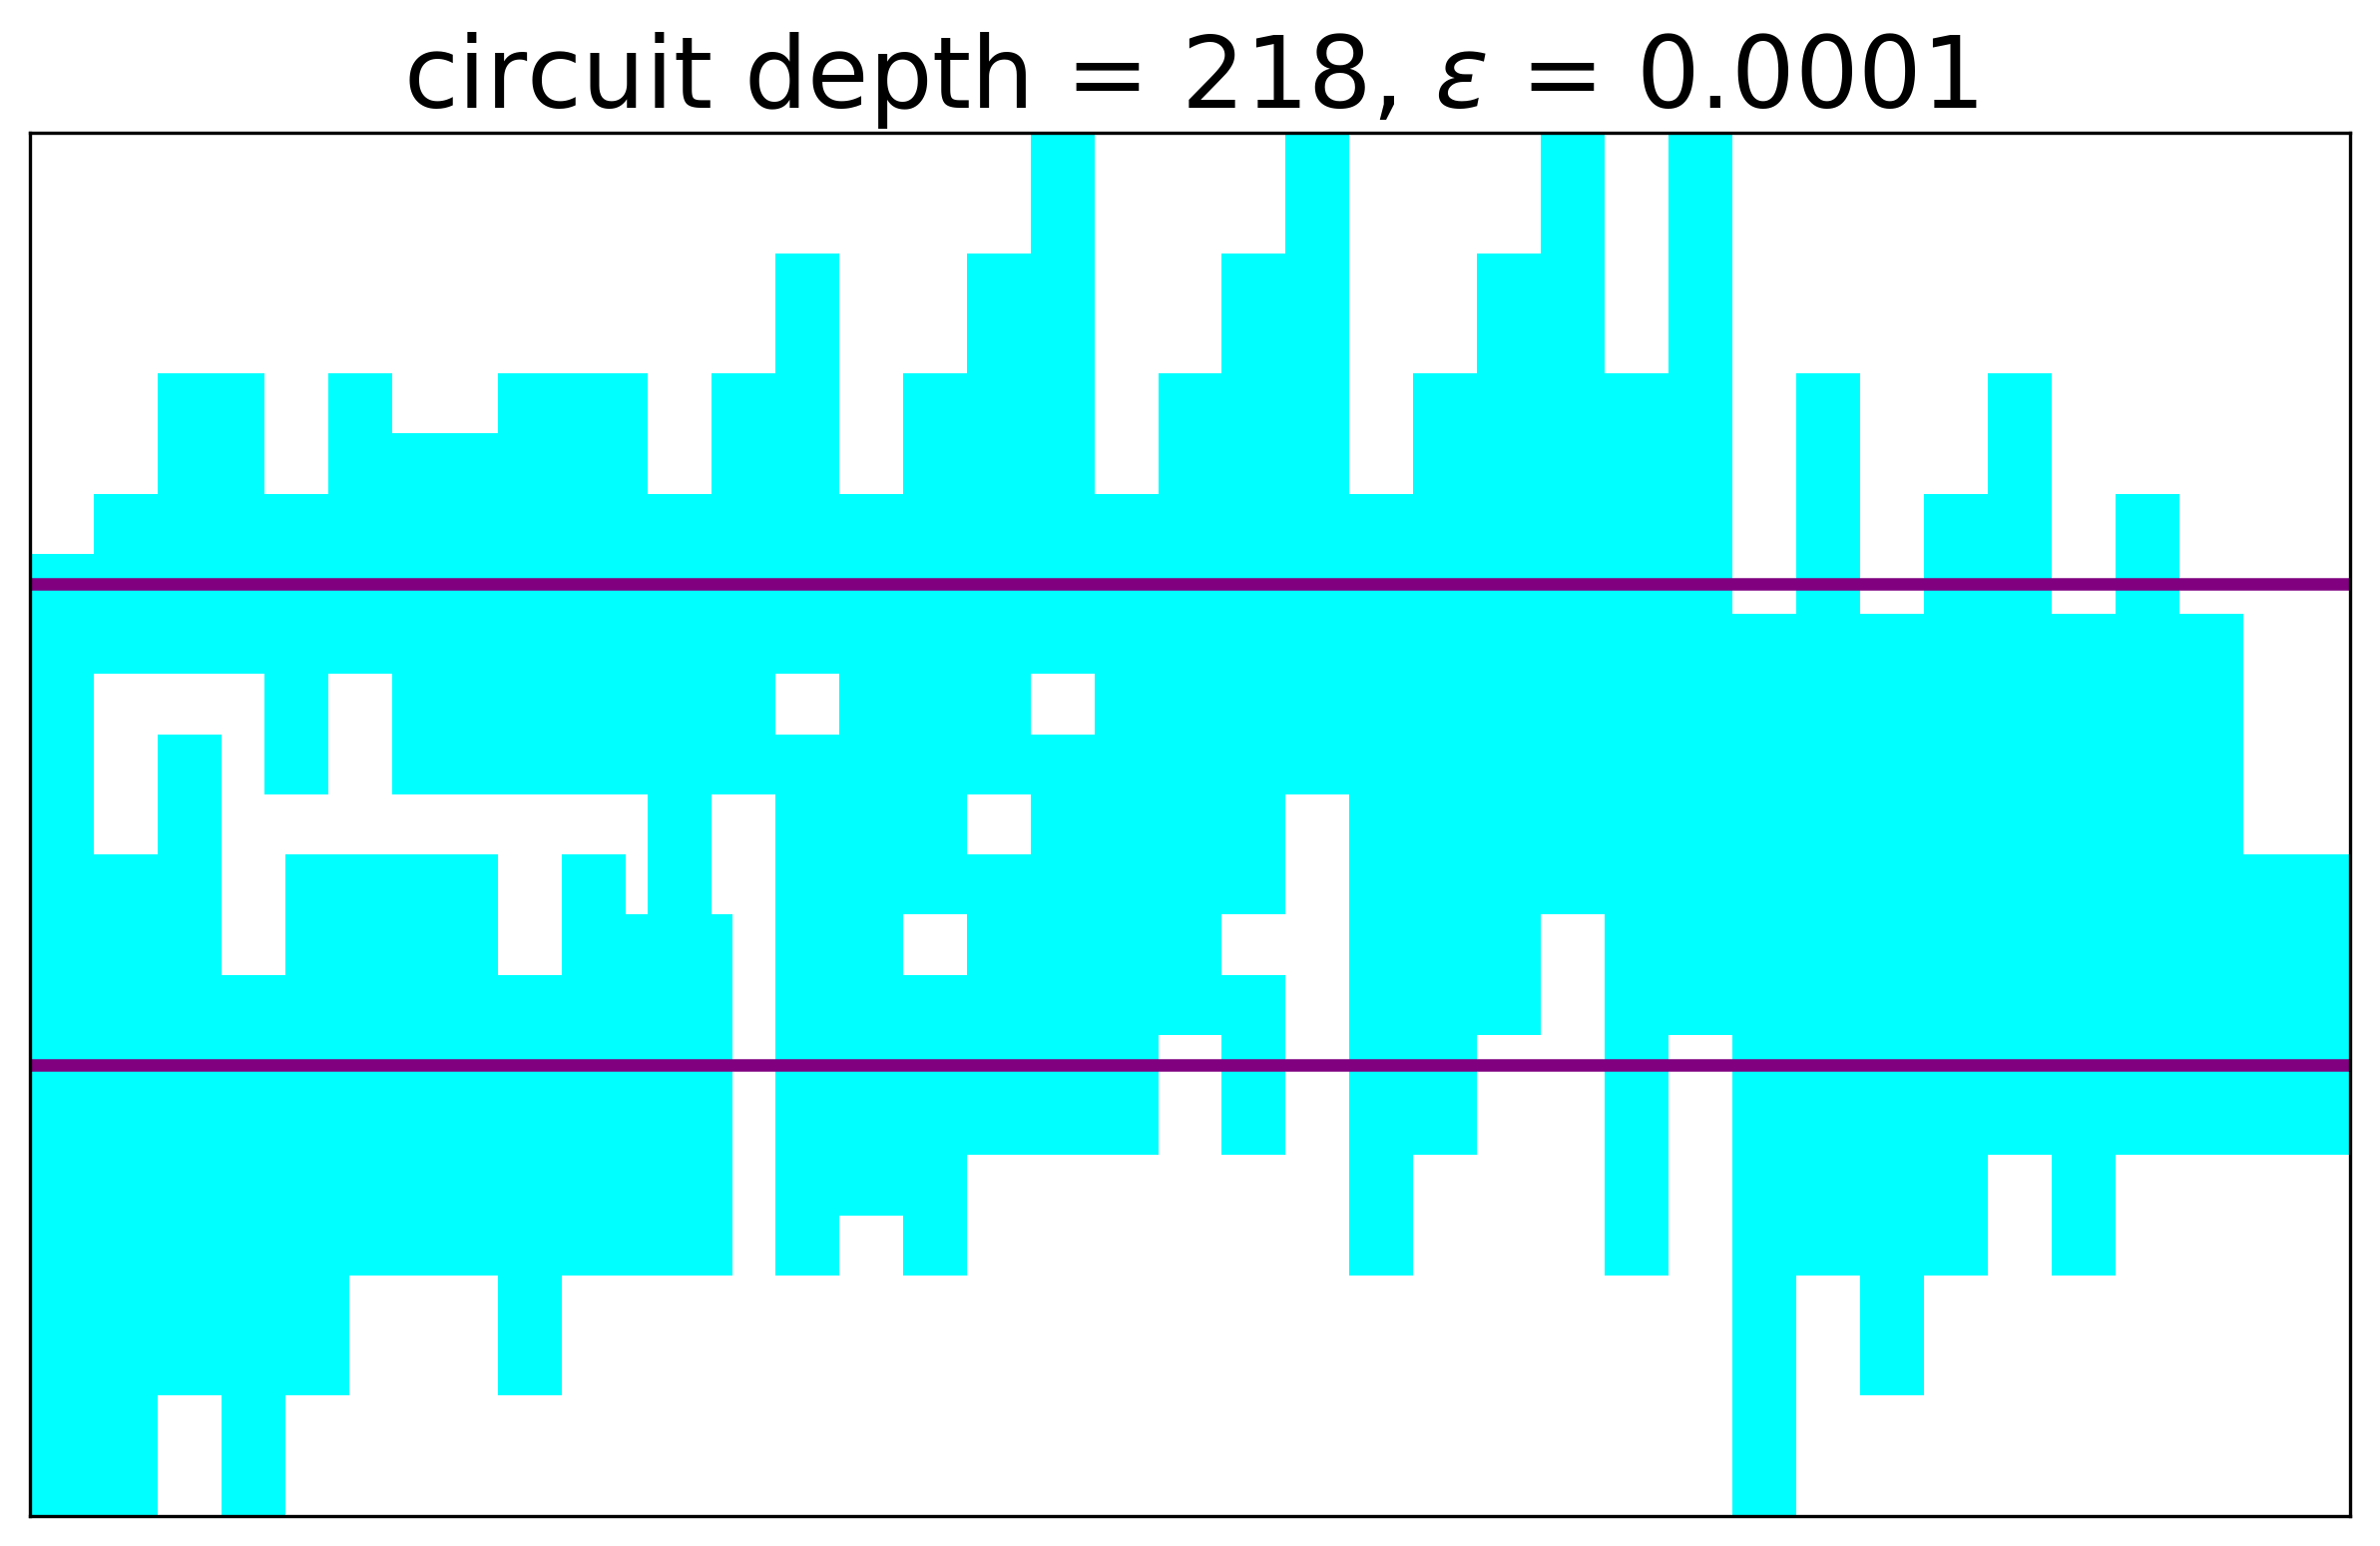

[]


In [ ]:
N = 24; f_orbs = (2,2,2,2,2,2)
epsilon_lst = [1e-4]
overlap_lst = []
seam_lst = [8,16]
ratio = 1
read_epsilon = 0.0
uop, all_g = read_uop(distance, read_epsilon, prehead)
prehead ="C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/data_H_12/"
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    excitations = create_excitation(uop, all_g, epsilon)
    excitations = orbital_reordering(excitations, f_orbs)
    if i == 0:
        overlap_lst ==[]
    else:
        pre_excitations = create_excitation(uop, all_g, epsilon_lst[i-1])
        pre_excitations = orbital_reordering(pre_excitations, f_orbs)
        overlap_lst = [sublist for sublist in excitations if sublist not in pre_excitations]
    tiles = create_circuit_tile(excitations, overlap_lst)
    post_tiles = process_tiles(tiles, ratio, seam_lst)
    
    packer = TilePacker(post_tiles,True)

    print("create complete")
    width, height, placed_tiles, grid = packer.pack_tiles()
    print(f"Bounding box size: {width} x {height}")
    print("Placed tiles:", placed_tiles)
    packer.draw_packing_overlap(grid,seam_lst,epsilon)
    print(overlap_lst)